In [1]:
# load R library for files
library(MCMCpack)
library(coda)
library(xtable)
library(kknn)
library(tictoc)

# setup parameter values
ndim = 2; nmcmc = 5000

Loading required package: coda
Loading required package: MASS
##
## Markov Chain Monte Carlo Package (MCMCpack)
## Copyright (C) 2003-2020 Andrew D. Martin, Kevin M. Quinn, and Jong Hee Park
##
## Support provided by the U.S. National Science Foundation
## (Grants SES-0350646 and SES-0350613)
##


In [2]:
#install.packages('d3heatmap')
library(d3heatmap)

Warning message:
"package 'd3heatmap' was built under R version 3.6.2"

In [3]:
#install.packages('gplots')
library('gplots')

Warning message:
"package 'gplots' was built under R version 3.6.2"
Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess



In [31]:
#install.packages('xlsx')
library(xlsx)
raw_data=read.xlsx('C:/Users/admin/내파일/지도교수님 면담/01_15_CBCL/CBCL/CBCL.xlsx',sheetIndex=1,startRow=2,header = T)

item_name=as.character(as.matrix(read.table('../item_name.txt')))

Warning message:
"package 'xlsx' was built under R version 3.6.3"

# load CBCL result

In [4]:
tic()
# load result files
CBCL_impute = as.matrix(read.table("../CBCL/result/impute.txt"))
CBCL_beta = as.matrix(read.table("../CBCL/result/beta.txt"))
CBCL_theta = as.matrix(read.table("../CBCL/result/theta.txt"))
nsample = ncol(CBCL_theta)
nitem = ncol(CBCL_beta)
CBCL_z = array(NA,dim=c(nmcmc,nsample,ndim))
CBCL_w = array(NA,dim=c(nmcmc,nitem,ndim))
for(j in 1:ndim){
  fopen = paste("../CBCL/result/z",j,".txt",sep="")
  CBCL_z[,,j] = as.matrix(read.table(fopen))
}
for(j in 1:ndim){
  fopen = paste("../CBCL/result/w",j,".txt",sep="")
  CBCL_w[,,j] = as.matrix(read.table(fopen))
}
CBCL_var_beta = scan("../CBCL/result/var_beta.txt")
CBCL_var_theta = scan("../CBCL/result/var_theta.txt")
CBCL_mle = scan("../CBCL/result/mle.txt")
toc()

tic()
# preparation of Procrustes matching
CBCL_max.address = which.max(CBCL_mle)
CBCL_w.star = CBCL_w[CBCL_max.address,,]
CBCL_z.star = CBCL_z[CBCL_max.address,,]
CBCL_w.proc = array(0,dim=c(nmcmc,nitem,ndim))
CBCL_z.proc = array(0,dim=c(nmcmc,nsample,ndim))

# Procrustes matching for latent spaces Z (respondent) and W (item)
for(iter in 1:nmcmc){
  CBCL_z.iter = CBCL_z[iter,,]
  CBCL_w.iter = CBCL_w[iter,,]
  if(iter != CBCL_max.address){
    CBCL_w.proc[iter,,] = procrustes(CBCL_w.iter,CBCL_w.star)$X.new
    CBCL_z.proc[iter,,] = procrustes(CBCL_z.iter,CBCL_z.star)$X.new
  }
  else{
    CBCL_w.proc[iter,,] = CBCL_w.iter
    CBCL_z.proc[iter,,] = CBCL_z.iter
  }
}
toc()

66.89 sec elapsed
27.91 sec elapsed


# load YSR result

In [5]:
tic()
# load result files
YSR_impute = as.matrix(read.table("../YSR/result/impute.txt"))
YSR_beta = as.matrix(read.table("../YSR/result/beta.txt"))
YSR_theta = as.matrix(read.table("../YSR/result/theta.txt"))
nsample = ncol(YSR_theta)
nitem = ncol(YSR_beta)
YSR_z = array(NA,dim=c(nmcmc,nsample,ndim))
YSR_w = array(NA,dim=c(nmcmc,nitem,ndim))
for(j in 1:ndim){
  fopen = paste("../YSR/result/z",j,".txt",sep="")
  YSR_z[,,j] = as.matrix(read.table(fopen))
}
for(j in 1:ndim){
  fopen = paste("../YSR/result/w",j,".txt",sep="")
  YSR_w[,,j] = as.matrix(read.table(fopen))
}
YSR_var_beta = scan("../YSR/result/var_beta.txt")
YSR_var_theta = scan("../YSR/result/var_theta.txt")
YSR_mle = scan("../YSR/result/mle.txt")
toc()

48.44 sec elapsed


In [6]:
tic()
# preparation of Procrustes matching
YSR_max.address = which.max(YSR_mle)
YSR_w.star = YSR_w[YSR_max.address,,]
YSR_z.star = YSR_z[YSR_max.address,,]
YSR_w.proc = array(0,dim=c(nmcmc,nitem,ndim))
YSR_z.proc = array(0,dim=c(nmcmc,nsample,ndim))

# Procrustes matching for latent spaces Z (respondent) and W (item)
for(iter in 1:nmcmc){
  YSR_z.iter = YSR_z[iter,,]
  YSR_w.iter = YSR_w[iter,,]
  if(iter != YSR_max.address){
    YSR_w.proc[iter,,] = procrustes(YSR_w.iter,YSR_w.star)$X.new
    YSR_z.proc[iter,,] = procrustes(YSR_z.iter,YSR_z.star)$X.new
  }
  else{
    YSR_w.proc[iter,,] = YSR_w.iter
    YSR_z.proc[iter,,] = YSR_z.iter
  }
}
toc()

24.21 sec elapsed


In [7]:
# CBCL_w.est=matrix(NA,nrow=nitem,ncol=2)
# CBCL_w.est[,1]=colMeans(CBCL_w.proc[,,1])
# CBCL_w.est[,2]=colMeans(CBCL_w.proc[,,2])

# YSR_w.est=matrix(NA,nrow=nitem,ncol=2)
# YSR_w.est[,1]=colMeans(YSR_w.proc[,,1])
# YSR_w.est[,2]=colMeans(YSR_w.proc[,,2])

In [8]:
tic()
YSR_w.est = matrix(NA,nitem,ndim)
YSR_z.est = matrix(NA,nsample,ndim)
for(i in 1:nitem){
  for(j in 1:ndim){
    YSR_w.est[i,j] = mean(YSR_w.proc[,i,j])
  }
}
for(k in 1:nsample){
  for(j in 1:ndim){
    YSR_z.est[k,j] = mean(YSR_z.proc[,k,j])
  }
}
toc()

YSR_beta.est=colMeans(YSR_beta)
YSR_theta.est=colMeans(YSR_theta)

0.26 sec elapsed


In [9]:
tic()
CBCL_w.est = matrix(NA,nitem,ndim)
CBCL_z.est = matrix(NA,nsample,ndim)
for(i in 1:nitem){
  for(j in 1:ndim){
    CBCL_w.est[i,j] = mean(CBCL_w.proc[,i,j])
  }
}
for(k in 1:nsample){
  for(j in 1:ndim){
    CBCL_z.est[k,j] = mean(CBCL_z.proc[,k,j])
  }
}
toc()

CBCL_beta.est=colMeans(CBCL_beta)
CBCL_theta.est=colMeans(CBCL_theta)

0.17 sec elapsed


In [10]:
# write.table(CBCL_beta.est,'../CBCL/result/CBCL_betaest.txt',row.names = F,col.names = F)
# write.table(CBCL_theta.est,'../CBCL/result/CBCL_thetaest.txt',row.names = F,col.names = F)
# write.table(CBCL_w.est,'../CBCL/result/CBCL_west.txt',row.names = F,col.names = F)
# write.table(CBCL_z.est,'../CBCL/result/CBCL_zest.txt',row.names = F,col.names = F)

In [11]:
# write.table(YSR_beta.est,'../YSR/result/YSR_betaest.txt',row.names = F,col.names = F)
# write.table(YSR_theta.est,'../YSR/result/YSR_thetaest.txt',row.names = F,col.names = F)
# write.table(YSR_w.est,'../YSR/result/YSR_west.txt',row.names = F,col.names = F)
# write.table(YSR_z.est,'../YSR/result/YSR_zest.txt',row.names = F,col.names = F)

# calculate KL-divergence

In [12]:
dim(CBCL_z.proc)
dim(CBCL_w.proc)

nitem=dim(CBCL_w.proc)[2]

[1] 5000  662    2

[1] 5000  118    2

In [13]:
KL_divergence=function(inp_samp1,inp_samp2,inp_round=1,inp_lb=0.1){
    stopifnot(length(inp_samp1)==length(inp_samp2))
    inp_samp1=round(inp_samp1,inp_round)
    inp_samp2=round(inp_samp2,inp_round)

    dist2=as.data.frame(table(inp_samp2))
    colnames(dist2)=c('axis','Freq')

    dist1=as.data.frame(table(inp_samp1))
    colnames(dist1)=c('axis','Freq')

    merged_dist=merge(x = dist1,  y = dist2,  by = 'axis', all = TRUE)
    merged_dist$axis=as.numeric(as.character(merged_dist$axis))
    merged_dist=merged_dist[order(merged_dist$axis),]
    merged_dist[is.na(merged_dist)]=0

    dist1=merged_dist$Freq.x
    dist2=merged_dist$Freq.y

    P=dist1+inp_lb
    Q=dist2+inp_lb

    return(sum(P*log(P/Q)))
    }

In [14]:
CBCL_dist=(rowSums((CBCL_w.proc[,1,]-CBCL_w.proc[,2,])**2))**0.5
YSR_dist=(rowSums((YSR_w.proc[,1,]-YSR_w.proc[,2,])**2))**0.5

KL_divergence(CBCL_dist,YSR_dist)

[1] 22357.18

In [15]:
tic()
dist_mat=matrix(NA,nrow=nitem,ncol=nitem)
for(i in 1:nitem){
    for(j in 1:nitem){
        if(i>=j){next}
        else{
        CBCL_dist=(rowSums((CBCL_w.proc[,i,]-CBCL_w.proc[,j,])**2))**0.5
        YSR_dist=(rowSums((YSR_w.proc[,i,]-YSR_w.proc[,j,])**2))**0.5
        dist_mat[i,j]=KL_divergence(CBCL_dist,YSR_dist)
        }
    }
}
toc()

187.12 sec elapsed


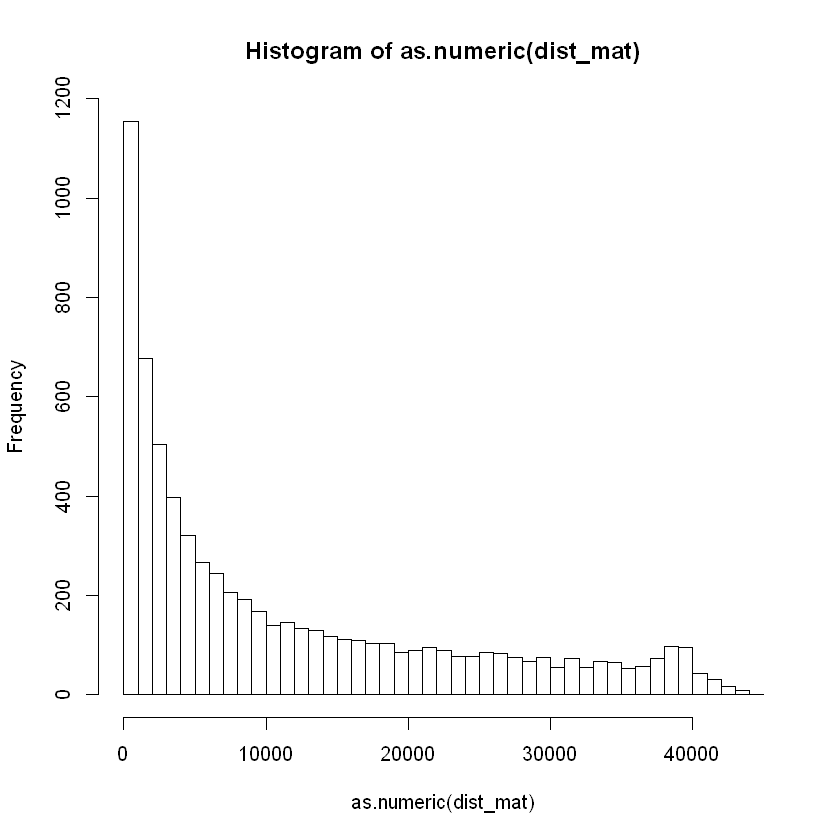

In [17]:
dist_mat=as.matrix(dist_mat)
colnames(dist_mat)=item_name

rownames(dist_mat)=item_name

hist(as.numeric(dist_mat),nclass=50)

In [18]:
sym_dist=t(replace(dist_mat,is.na(dist_mat),0))+replace(dist_mat,is.na(dist_mat),0)

Warning message in heatmap.2(sym_dist, scale = "none", col = bluered(100), trace = "none", :
"Discrepancy: Rowv is FALSE, while dendrogram is `both'. Omitting row dendogram."Warning message in heatmap.2(sym_dist, scale = "none", col = bluered(100), trace = "none", :
"Discrepancy: Colv is FALSE, while dendrogram is `column'. Omitting column dendogram."

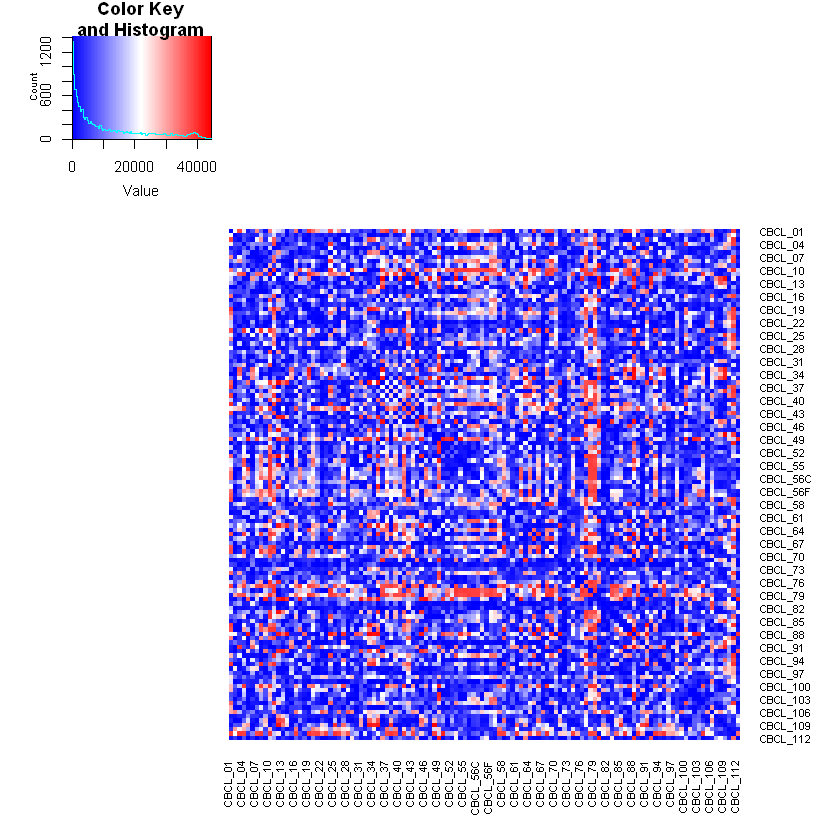

In [19]:
heatmap.2(sym_dist,scale='none',col=bluered(100),trace='none',symm = T,Rowv=F,Colv=F)

$rowInd
  [1]  94  49  41  84  10  85  11  70   1 117  83 107  51  54 116  42  32  59
 [19]  76 106  55  82 115  66 114  86  69  98  44  60  56  36  89  53  93  75
 [37]  71  24  57  58  62  61  34  97  33  45  14  77  12  35  31  13   9  91
 [55]   5  50 118 109  18  30  81 108  52  29  47  40   6  15  65 113  79  21
 [73]  26  73  78  88 111 105   2 102  87  96 100  67 103  22  28  23 104 112
 [91]   8  72  64   7  80 110  99  17  46  68  48  38  90   3  92  19 101  74
[109]  27  25  95   4  20  39  37  63  43  16

$colInd
  [1]  94  49  41  84  10  85  11  70   1 117  83 107  51  54 116  42  32  59
 [19]  76 106  55  82 115  66 114  86  69  98  44  60  56  36  89  53  93  75
 [37]  71  24  57  58  62  61  34  97  33  45  14  77  12  35  31  13   9  91
 [55]   5  50 118 109  18  30  81 108  52  29  47  40   6  15  65 113  79  21
 [73]  26  73  78  88 111 105   2 102  87  96 100  67 103  22  28  23 104 112
 [91]   8  72  64   7  80 110  99  17  46  68  48  38  90   3  92  19 101  74
[

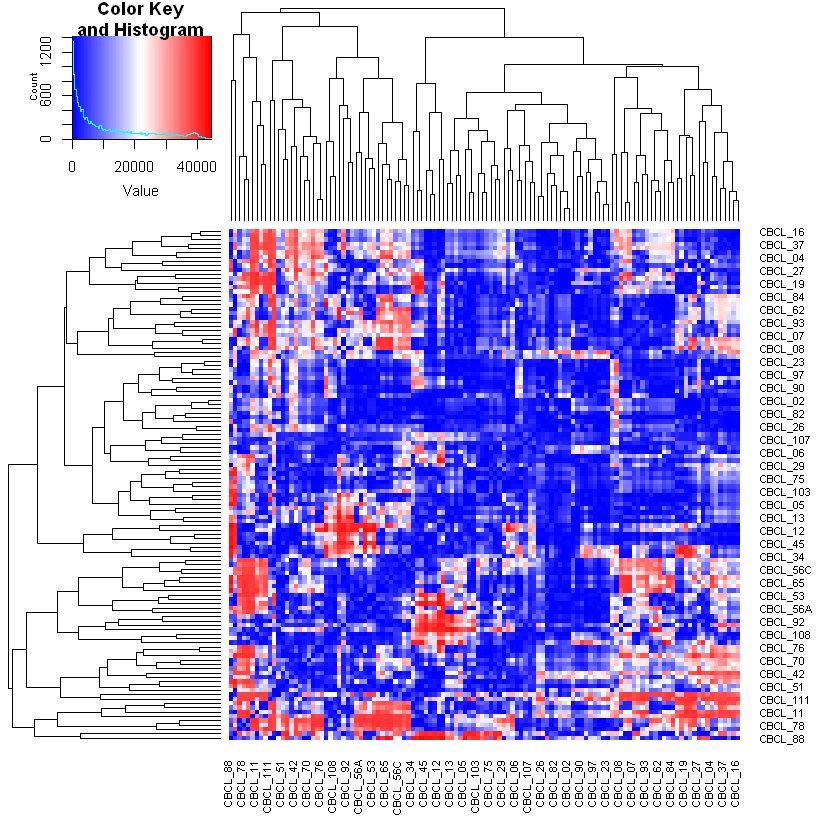

In [22]:
A=heatmap.2(sym_dist,scale='none',col=bluered(100),trace='none')

A

### item pair wise로 보기

In [26]:
tmp=unique(as.numeric(dist_mat))
#threshold=(tmp[order(tmp)])[10]
threshold=as.numeric(quantile(tmp,na.rm = T,probs = 0.99))

diff_mat=which(dist_mat>threshold, arr.ind = T)
diff_mat[,2]=item_name[as.numeric(diff_mat[,2])]
diff_mat[,1]=item_name[as.numeric(diff_mat[,1])]
diff_mat[order(diff_mat[,1]),]
table(diff_mat[order(diff_mat[,1]),1])

# colSum해서 item자체로 보기

In [44]:
high_KL=names(colSums(sym_dist)[order(colSums(sym_dist),decreasing = T)][1:10])

In [45]:
raw_data[raw_data$Variable%in%high_KL,c('Question','Variable')]

,Question,Variable
1,1. Acts too young for his/her age,CBCL_01
10,"10. Can't sit still, restless or hyperactive",CBCL_10
11,11. Clings to adults or too dependent,CBCL_11
42,42. Would rather be along than with others,CBCL_42
49,"49. Constipated, doesn't move bowels",CBCL_49
85,77. Sleeps more than most kids during day and/or night,CBCL_77
86,78. Inattentive or easily distracted,CBCL_78
87,79. Speech problem,CBCL_79
96,88. Sulks a lot,CBCL_88
119,"111. Withdrawn, doesn't get inolved with others",CBCL_111


In [56]:
# CBCL_w.proc.proc = array(0,dim=c(nmcmc,nitem,ndim))
# CBCL_z.proc.proc = array(0,dim=c(nmcmc,nsample,ndim))

# # Procrustes matching for latent spaces Z (respondent) and W (item)
# for(iter in 1:nmcmc){
#   CBCL_z.iter = CBCL_z[iter,,]
#   CBCL_w.iter = CBCL_w[iter,,]
#   if(iter != CBCL_max.address){
#     CBCL_w.proc.proc[iter,,] = procrustes(CBCL_w.iter,YSR_w.star)$X.new
#     CBCL_z.proc.proc[iter,,] = procrustes(CBCL_z.iter,YSR_z.star)$X.new
#   }
#   else{
#     CBCL_w.proc.proc[iter,,] = CBCL_w.iter
#     CBCL_z.proc.proc[iter,,] = CBCL_z.iter
#   }
# }
# toc()

# i=1
# k=2
# YSR_dist=(rowSums((YSR_w.proc[,i,]-YSR_w.proc[,j,])**2))**0.5
# CBCL_dist=(rowSums((CBCL_w.proc[,i,]-CBCL_w.proc[,j,])**2))**0.5
# CBCL_dist2=(rowSums((CBCL_w.proc.proc[,i,]-CBCL_w.proc.proc[,j,])**2))**0.5

# visualize unmatching items

In [23]:
CBCL_w.est_pr=procrustes(CBCL_w.est,YSR_w.est)$X.new

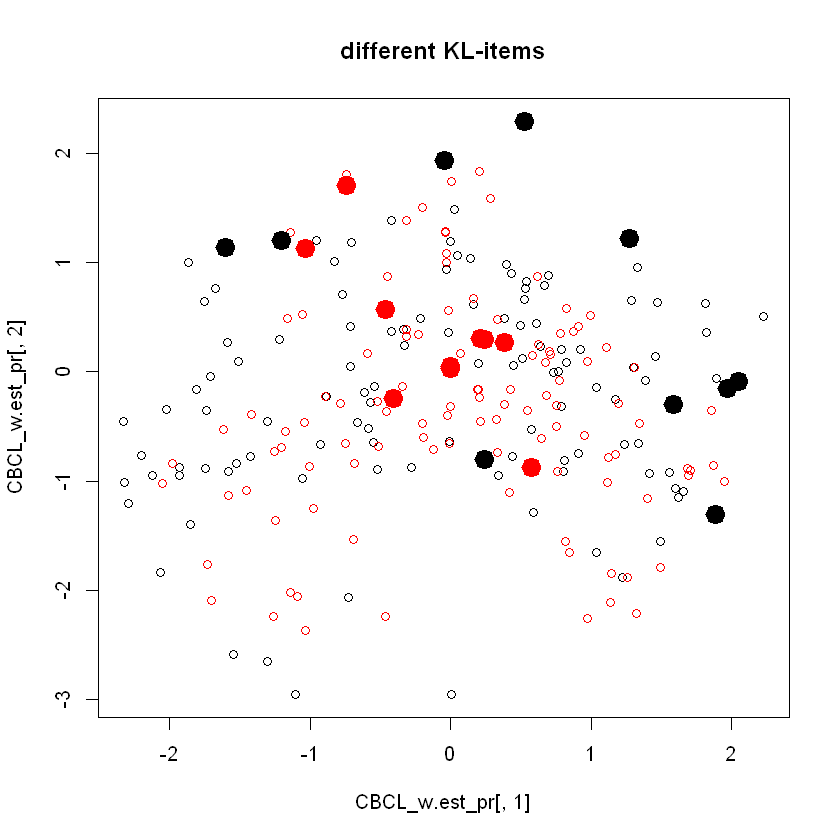

In [62]:
target_idx=high_KL

#target_idx='CBCL_59'
plot(CBCL_w.est_pr[,1],CBCL_w.est_pr[,2],col=1,main='different KL-items')
points(YSR_w.est[,1],YSR_w.est[,2],col=2)

points(CBCL_w.est_pr[item_name %in%target_idx,1],CBCL_w.est_pr[item_name %in%target_idx,2],col=1,lwd = 10)
points(YSR_w.est[item_name %in%target_idx,1],YSR_w.est[item_name %in%target_idx,2],col=2,lwd = 10)

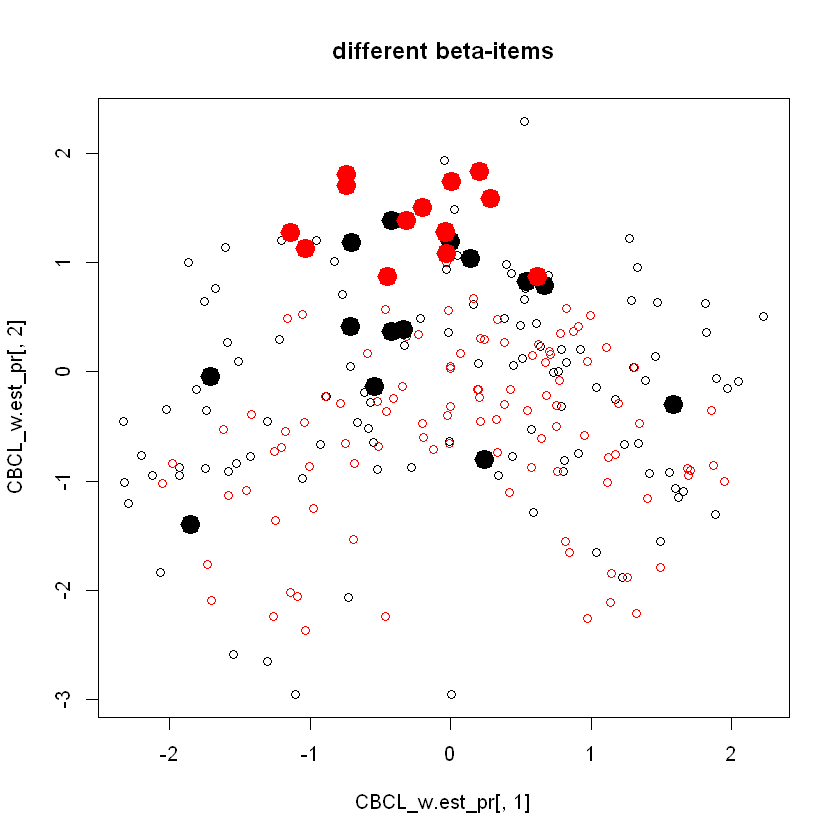

In [63]:
target_idx=c('CBCL_06','CBCL_15','CBCL_49','CBCL_59','CBCL_60','CBCL_73','CBCL_80','CBCL_88','CBCL_92','CBCL_98','CBCL_106','CBCL_107','CBCL_108','CBCL_109')

#target_idx='CBCL_59'
plot(CBCL_w.est_pr[,1],CBCL_w.est_pr[,2],col=1,main='different beta-items')
points(YSR_w.est[,1],YSR_w.est[,2],col=2)

points(CBCL_w.est_pr[item_name %in%target_idx,1],CBCL_w.est_pr[item_name %in%target_idx,2],col=1,lwd = 10)
points(YSR_w.est[item_name %in%target_idx,1],YSR_w.est[item_name %in%target_idx,2],col=2,lwd = 10)